In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

# always import gbm_algos first !
import xgboost, lightgbm, catboost
from gplearn.genetic import SymbolicRegressor

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from preprocess import *

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew
# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder

# Distance loss
from geomloss import SamplesLoss

# Model selection
from sparsereg.model import STRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from RegscorePy.bic import bic

# Tracking
from tqdm import trange

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
include_N_res = True

x_limit = 300
t_limit = 100

DATA_PATH = '../PDE_FIND_experimental_datasets/kuramoto_sivishinky.mat'
X, T, Exact = space_time_grid(data_path=DATA_PATH, real_solution=True, uniform=True, x_limit=None, t_limit=None)
X_star, u_star = get_trainable_data(X, T, Exact)

# Domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

N = x_limit*t_limit
if N == X_star.shape[0]:
    print("Using the entire domain")
    include_N_res = False
    
print(f"Training with {N} samples")

# idx = np.random.choice(X_star.shape[0], N, replace=False)
idx = np.arange(N) # arange for faster training due to the easy data

X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

# Unsup data
if include_N_res:
    N_res = N//2
    idx_res = np.array(range(X_star.shape[0]-1))[~idx]
    idx_res = np.random.choice(idx_res.shape[0], N_res, replace=True)
    X_res = X_star[idx_res, :]
    print(f"Training with {N_res} unsup samples")
    X_u_train = np.vstack([X_u_train, X_res])
    u_train = np.vstack([u_train, torch.rand(X_res.shape[0], 1) - 1000])
    # del X_res
else: print("Not including N_res")
    
# Convert to torch.tensor
X_u_train = to_tensor(X_u_train, True)
u_train = to_tensor(u_train, False)
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)

# lb and ub are used in adversarial training
scaling_factor = 1.0
lb = scaling_factor*to_tensor(lb, False)
ub = scaling_factor*to_tensor(ub, False)

# Feature names
feature_names=('uf', 'u_x', 'u_xx', 'u_xxx', 'u_xxxx')

Data is arranged in an uniform grid
Training with 30000 samples
Training with 15000 unsup samples


In [3]:
fdc = FinDiffCalculator(X, T, Exact, acc_order=10)

# Even if you use the true vals of dx and dt -> The finite difference is not working with a non-uniform grid
fdc.dx = 0.09817477042468103
fdc.dt = 0.4

fd_u_t = to_tensor(fdc.finite_diff(1, diff_order=1), False)[idx, :]
fd_derivatives = fdc.finite_diff_from_feature_names(feature_names)
for d in fd_derivatives: fd_derivatives[d] = to_tensor(fd_derivatives[d], False)

Do not use this class with complex-valued input arrays.
This class applies 1 transpose to the Exact before doing the job.
dx = 0.09817477042468103
dt = 0.4


In [4]:
tmp = None
for f in feature_names:
    print('Concatenating', f)
    if tmp == None: tmp = fd_derivatives[f]
    else: tmp = torch.cat([tmp, fd_derivatives[f]], dim=-1)
fd_derivatives = tmp[idx, :]
(((fd_u_t+fd_derivatives[:, 4:5]+(fd_derivatives[:, 0:1]*fd_derivatives[:, 1:2])+fd_derivatives[:, 2:3]))**2).mean().item()

Concatenating uf
Concatenating u_x
Concatenating u_xx
Concatenating u_xxx
Concatenating u_xxxx


6.793009904582092e-11

In [5]:
X_input = fd_derivatives
y_input = fd_u_t

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_input = poly.fit_transform(X_input)
poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names):
    poly_feature_names[i] = f.replace(" ", "*")

from sparsereg.model import STRidge
# print(STRidge(unbias=False).fit(fd_derivatives, fd_u_t.ravel()).coef_)
coef = STRidge(threshold=0.01, alpha=0.1, max_iter=1000, normalize=True).fit(X_input, y_input.ravel()).coef_
idxs = np.argsort(np.abs(coef))[::-1]

for idx in idxs[:]:
    if not np.isclose(coef[idx], 0.0):
        print(str(coef[idx])+poly_feature_names[idx], end="")

-1.0000315917550011u_xx-1.0000125811028373u_xxxx-0.9999838361820689uf*u_x

In [6]:
class Network(nn.Module):
    def __init__(self, model, index2features=None, scale=False, lb=None, ub=None):
        super(Network, self).__init__()
        # pls init the self.model before
        self.model = model
        # For tracking, the default tup is for the burgers' equation.
        self.index2features = index2features
        print("Considering", self.index2features)
        self.diff_flag = diff_flag(self.index2features)
        self.uf = None
        self.scale = scale
        self.lb, self.ub = lb, ub
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x, t):
        if not self.scale: self.uf = self.model(torch.cat([x, t], dim=1))
        else: self.uf = self.model(self.neural_net_scale(torch.cat([x, t], dim=1)))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        
        ### PDE Loss calculation ###
        # Without calling grad
        derivatives = []
        for t in self.diff_flag[0]:
            if t=='uf': derivatives.append(uf)
            elif t=='x': derivatives.append(x)
        # With calling grad
        for t in self.diff_flag[1]:
            out = uf
            for c in t:
                if c=='x': out = self.gradients(out, x)[0]
                elif c=='t': out = self.gradients(out, t)[0]
            derivatives.append(out)
        
        return torch.cat(derivatives, dim=1), u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))
    
    def neural_net_scale(self, inp):
        return 2*(inp-self.lb)/(self.ub-self.lb)-1

In [7]:
class SeclectorNetwork(nn.Module):
    def __init__(self, X_train_dim, bn=None):
        super().__init__()
        # Nonlinear model, Training with PDE reg.
        self.nonlinear_model = TorchMLP(dimensions=[X_train_dim, 50, 50, 1], activation_function=nn.Tanh, bn=bn, dropout=nn.Dropout(p=0.1), inp_drop=False)
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, inn):
        ut_approx = self.nonlinear_model(inn)
        return ut_approx
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        return mse_loss


class AttentionSelectorNetwork(nn.Module):
    def __init__(self, layers, prob_activation=torch.sigmoid, bn=None, reg_intensity=0.1):
        super(AttentionSelectorNetwork, self).__init__()
        # Nonlinear model, Training with PDE reg.
        assert len(layers) > 1
        self.linear1 = nn.Linear(layers[0], layers[0])
        self.prob_activation = prob_activation
        self.nonlinear_model = TorchMLP(dimensions=layers, activation_function=nn.Tanh, bn=bn, dropout=nn.Dropout(p=0.1))
        self.latest_weighted_features = None
        self.th = 0.1
        self.reg_intensity = reg_intensity
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn):
        return self.nonlinear_model(inn*self.weighted_features(inn))
    
    def weighted_features(self, inn):
        self.latest_weighted_features = self.prob_activation(self.linear1(inn)).mean(axis=0)
        return self.latest_weighted_features
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        reg_term = F.relu(self.latest_weighted_features-self.th)
        return mse_loss+self.reg_intensity*(torch.norm(reg_term, p=0)+(torch.tensor([1.0, 1.0, 2.0, 3.0, 4.0])*reg_term).sum())

# Only the SemiSupModel has changed to work with the finite difference guidance
class SemiSupModel(nn.Module):
    def __init__(self, network, selector, normalize_derivative_features=False, mini=None, maxi=None):
        super(SemiSupModel, self).__init__()
        self.network = network
        self.selector = selector
        self.normalize_derivative_features = normalize_derivative_features
        self.mini = mini
        self.maxi = maxi
        
    def forward(self, X_u_train, fd_derivatives=None, fd_u_t=None, fd_weight=0.0, include_unsup=True):
        X_selector, y_selector = self.network.get_selector_data(*dimension_slicing(X_u_train))
        
        fd_guidance = 0.0
        if fd_weight>0.0 and fd_derivatives is not None and fd_u_t is not None:
            # Traditional MSE Loss btw uf and u_train + the fd_guidance loss
            row, col = fd_derivatives.shape
            fd_guidance += F.mse_loss(X_selector[:row, 0:1], fd_derivatives[:, 0:1])
            fd_guidance += fd_weight*(col-1)*F.mse_loss(X_selector[:row, 1:], fd_derivatives[:, 1:])
            fd_guidance += fd_weight*F.mse_loss(y_selector[:row, :], fd_u_t)
            
        else: fd_guidance = self.network.uf
            
        if self.normalize_derivative_features:
            X_selector = (X_selector-self.mini)/(self.maxi-self.mini)
        
        if include_unsup: unsup_loss = self.selector.loss(X_selector, y_selector)
        else: unsup_loss = None
        
        return fd_guidance, unsup_loss

In [8]:
### Version with normalized derivatives ###
# pretrained_state_dict = torch.load("./saved_path_inverse_ks/pretrained5000samples_semisup_model_with_LayerNormDropout_without_physical_reg.pth")
pretrained_state_dict = cpu_load("./saved_path_inverse_ks/semisup_model_with_LayerNormDropout_without_physical_reg_trained30000labeledsamples_trained15000unlabeledsamples.pth")
# pretrained_state_dict = None
use_pretrained_weights = True
lets_pretrain = not use_pretrained_weights

semisup_model = SemiSupModel(network=Network(
                                    model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1],
                                                   activation_function=nn.Tanh,
                                                   bn=nn.LayerNorm, dropout=None),
                                    index2features=feature_names, scale=True, lb=lb, ub=ub),
                            selector=AttentionSelectorNetwork([len(feature_names), 50, 50, 1], prob_activation=nn.Softmax(dim=1), bn=nn.LayerNorm),
                            normalize_derivative_features=True,
                            mini=None,
                            maxi=None)

if use_pretrained_weights:
    print("Use pretrained weights")
    semisup_model.load_state_dict(pretrained_state_dict)
#     referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
#     semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
#     semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.mini = tmp.min(axis=0)[0].requires_grad_(False)
    semisup_model.maxi = tmp.max(axis=0)[0].requires_grad_(False)

# Highly inefficient code here
# Why I cannnot load the network state_dict inside the if statement???
tmp = SemiSupModel(network=Network(
                                    model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1],
                                                   activation_function=nn.Tanh,
                                                   bn=nn.LayerNorm, dropout=None),
                                    index2features=feature_names, scale=True, lb=lb, ub=ub),
                            selector=AttentionSelectorNetwork([len(feature_names), 50, 50, 1], prob_activation=nn.Softmax(dim=1), bn=nn.LayerNorm),
                            normalize_derivative_features=True,
                            mini=None,
                            maxi=None)
tmp.load_state_dict(pretrained_state_dict); network_state_dict = tmp.network.state_dict()
del tmp, pretrained_state_dict

Using old implementation of TorchMLP. See models.py for more new model-related source code.
Considering ('uf', 'u_x', 'u_xx', 'u_xxx', 'u_xxxx')
Using old implementation of TorchMLP. See models.py for more new model-related source code.
Use pretrained weights
Using old implementation of TorchMLP. See models.py for more new model-related source code.
Considering ('uf', 'u_x', 'u_xx', 'u_xxx', 'u_xxxx')
Using old implementation of TorchMLP. See models.py for more new model-related source code.


In [9]:
# Chk the performance both MSE and PDE relation loss
semisup_model.eval()
print(F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item())
referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_u_train))
(((u_t+referenced_derivatives[:, 4:5]+(referenced_derivatives[:, 0:1]*referenced_derivatives[:, 1:2])+referenced_derivatives[:, 2:3]))**2).mean().item()

9.25849437713623


0.0007950526778586209

In [10]:
if lets_pretrain:
    print("Pretraining")
    pretraining_optimizer = LBFGSNew(semisup_model.network.parameters(), 
                                     lr=1e-1, max_iter=300, 
                                     max_eval=int(300*1.25), history_size=150, 
                                     line_search_fn=True, batch_mode=False)
#     pretraining_optimizer =  MADGRAD(semisup_model.network.parameters(), lr=1e-3, momentum=0.9)
    
    best_state_dict = None; curr_loss = 1000
    semisup_model.network.train()
    for i in range(300):
        def pretraining_closure():
            global N, X_u_train, u_train
            if torch.is_grad_enabled():
                pretraining_optimizer.zero_grad()
            # Only focusing on first [:N, :] elements
            mse_loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_u_train[:N, :])), u_train[:N, :])
            if mse_loss.requires_grad:
                mse_loss.backward(retain_graph=False)
            return mse_loss

        pretraining_optimizer.step(pretraining_closure)

        l = pretraining_closure()
        
        if l.item() < curr_loss:
            curr_loss = l.item()
            best_state_dict = semisup_model.state_dict()
            
        if (i%10)==0:
            print("Epoch {}: ".format(i), curr_loss)

            # Sneak on the test performance...
            semisup_model.network.eval()
            test_performance = F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()
            string_test_performance = scientific2string(test_performance)
            print('Test MSE:', string_test_performance)
    
    print("Computing derivatives features")
    semisup_model.eval()
    referenced_derivatives, _ = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
    
#     semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
#     semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

    semisup_model.mini = tmp.min(axis=0)[0].requires_grad_(False)
    semisup_model.maxi = tmp.max(axis=0)[0].requires_grad_(False)

In [11]:
def pcgrad_closure():
    global N, X_u_train, u_train, fd_derivatives, fd_u_t
    fd_guidance, unsup_loss = semisup_model(X_u_train, fd_derivatives=fd_derivatives, 
                                            fd_u_t=fd_u_t, fd_weight=1.0, include_unsup=True)
    losses = [fd_guidance, unsup_loss]
    updated_grads = []
    
    for i in range(2):
        optimizer1.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in semisup_model.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(semisup_model.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    return sum(losses)

def selector_closure():
    global ders, dys
    if torch.is_grad_enabled():
        optimizer3.zero_grad()
    unsup_loss = semisup_model.selector.loss(ders, dys)
    if unsup_loss.requires_grad:
        unsup_loss.backward(retain_graph=True)
    return unsup_loss

In [12]:
params = semisup_model.parameters()

### For SGD and Adam ###
learning_rate1, learning_rate2 = 1e-7, 1e-1

### For LBFGS (a good choice already!!!) ###
# print("Using LBFGS's learning rate set")
# learning_rate1, learning_rate2 = 8e-2, 5e-2 # (1e-1, 5e-2) is also OK!

choice = 'MAD'; auto_lr = False
if choice == 'LBFGS':
    optimizer1 = torch.optim.LBFGS(params, lr=learning_rate1, 
                                   max_iter=100, max_eval=125, 
                                  history_size=120, line_search_fn='strong_wolfe')
if choice == 'Adam':
    optimizer1 = AdamGC(params, lr=learning_rate1, use_gc=True, gc_conv_only=False, gc_loc=False)
if choice == 'SGD':
    optimizer1 = SGDGC(params, lr=learning_rate1, use_gc=True, nesterov=True, momentum=0.95)
if choice == 'MAD':
    optimizer1 = MADGRAD(params, lr=learning_rate1, momentum=0.9)

if choice != 'LBFGS' and auto_lr:
    print('Learning rate finding')
    bs = 4000; bs = X_u_train.shape[0] if bs>X_u_train.shape[0] else bs
    criterion = LadderLoss(return_list=True)
    trainloader = get_dataloader(X_u_train, u_train, bs=bs)
    
    lr_finder = LRFinder(semisup_model, optimizer=optimizer1, 
                         closure=pcgrad_update, criterion=criterion, device="cpu")
    lr_finder.range_test(trainloader, val_loader=None, end_lr=100, num_iter=300)
    
    # to inspect the loss-learning rate graph
    suggested_lr, _ = lr_finder.plot()
    # To prevent divergence during the second stage training.
    # suggested_lr = min(suggested_lr, 5e-3)
    lr_finder.reset(); plt.show()

else:
    lr_finder = None
    suggested_lr = None

In [13]:
print("Deleted the fake labels used in Learning rate finder")
u_train = u_train[:N, :]

suggested_lr = 1e-6

if lr_finder and suggested_lr:
    optimizer1 = lr_finder.optimizer

print("Assigning the suggested_lr to optimizer1")
for g in optimizer1.param_groups:
    g['lr'] = suggested_lr

epochs1 = 200; epochs2 = 100;

Deleted the fake labels used in Learning rate finder
Assigning the suggested_lr to optimizer1


### Adversarial training

In [14]:
# # Setting up the generator
# generator = TorchMLP([2, 50, 50, 2])
# # generator_training_epochs indicates how string the generator is
# adv_f = 100; generator_training_epochs = 500; generator_training_limit = epochs1-100
# # I can use the Learning rate finder to find a good lr for the generator optim  as well
# generator_optimizer = MADGRAD(generator.parameters(), lr=1e-3, momentum=0.95)
# # sinkhorn distance loss
# distance_func = distance_loss

In [15]:
# curr_loss = 500; F_print = 10 if choice == 'LBFGS' else 100

# # Stage I
# # How long should I pretrain selector part of the model?
# for i in range(epochs1):
#     if i%adv_f==0 and i<=generator_training_limit:
#         best_generator_loss = 1e6; best_generator_state_dict = None
#         o_tensor = X_u_train[:N, :] # or X_u_train ?
#         print("Training the generator for ")
#         for _ in trange(generator_training_epochs):
#             semisup_model.eval()
#             generator.train()
#             generator_optimizer.zero_grad()
            
#             # Do I need to scale o_tensor before feeding into the generator?
#             X_gen = scale_to_range(generator(o_tensor), lb, ub)
#             unsup_loss = semisup_model(X_gen)[1]
            
#             # Choose the distance function that works well with the X_u_train structure
#             d_loss = distance_func(X_gen, o_tensor)
# #             d_loss = F.mse_loss(X_gen, o_tensor)
#             generator_loss = 0.05*d_loss-unsup_loss
#             generator_loss.backward(retain_graph=True)
#             generator_optimizer.step()
            
#             # Saving the best_generator_state_dict
#             if generator_loss.item() < best_generator_loss:
#                 best_generator_loss = generator_loss.item()
#                 best_generator_state_dict = generator.state_dict()

#         print("The best generator loss:", best_generator_loss)
#         if best_generator_state_dict is not None: 
#             generator.load_state_dict(best_generator_state_dict)
            
#         generator.eval()
#         X_gen = scale_to_range(generator(o_tensor), lb, ub)
#         if N_res<X_gen.shape[0]: X_gen = sampling_from_rows(X_gen, N_res)
#         X_u_train = torch.cat([X_u_train[:N, :], X_gen], dim=0).detach().requires_grad_(True)

#     semisup_model.train()
#     generator_optimizer.zero_grad()
#     optimizer1.step(pcgrad_closure)
#     l = pcgrad_closure()
#     if (i % F_print) == 0:
#         if l.item() != curr_loss:
#             curr_loss = l.item()
#         else:
#             print("Semi-supervised solver loss @Epoch {}: ".format(i), curr_loss)
#             print("Finishing the first stage")
#             break
#         print("Semi-supervised solver loss @Epoch {}: ".format(i), curr_loss)
        
# # Re init
# with torch.no_grad(): semisup_model.network.load_state_dict(network_state_dict)

#### Fine-tuning the solver network

In [16]:
# # Stage II: Train semisup_model.network
# def closure():
#     global N, X_u_train, u_train, fd_derivatives, fd_u_t
#     if torch.is_grad_enabled():
#         optimizer2.zero_grad()
#     # With fd guidance
#     mse_loss = semisup_model(X_u_train, fd_derivatives, fd_u_t, 2.0, False)[0]
#     if mse_loss.requires_grad:
#         mse_loss.backward(retain_graph=True)
#     return mse_loss

# # optimizer2 = torch.optim.LBFGS(semisup_model.network.parameters(), 
# #                                      lr=1e-1, max_iter=100, 
# #                                      max_eval=int(100*1.25), history_size=150, 
# #                                      line_search_fn='strong_wolfe')

# optimizer2 = MADGRAD(semisup_model.network.parameters(), lr=1e-6, momentum=0.95)

# curr_loss = 10000
# semisup_model.network.train()
# semisup_model.selector.eval()
# for i in range(epochs2):
#     optimizer2.step(closure)
#     if (i % 2) == 0:
#         l = closure()
#         if l.item() != curr_loss:
#             curr_loss = l.item()
#         print("Epoch {}: ".format(i), curr_loss)

#### Sparse regression

In [17]:
fd_derivatives = to_numpy(fd_derivatives)
fd_u_t = to_numpy(fd_u_t)

In [18]:
n_test = 12000
referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_star[:n_test, :]))
referenced_derivatives = to_numpy(referenced_derivatives); u_t = to_numpy(u_t)
print((((u_t+referenced_derivatives[:, 4:5]+(referenced_derivatives[:, 0:1]*referenced_derivatives[:, 1:2])+referenced_derivatives[:, 2:3]))**2).mean().item())

alpha = 1
const_range = (-1.5, 1.5)

X_input = alpha*referenced_derivatives+(1-alpha)*fd_derivatives[:n_test, :]
y_input = alpha*u_t+(1-alpha)*fd_u_t[:n_test, :]

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_input = poly.fit_transform(X_input)
poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names):
    poly_feature_names[i] = f.replace(" ", "*")

0.0003179807390552014


#### Also https://cran.r-project.org/web/packages/L0Learn/vignettes/L0Learn-vignette.html is useful For finding PDE

In [19]:
# My trick to make it work
# threshold=0.02 -> alpha=1.0 to alpha=100.0, normalize=False
# threshold=0.01 -> alpha=0.5 to alpha=500.0, normalize=True
# Is this bullshit???

# TODO: Try find min -np.log(MSE/maxMSE)/(Complexity - minComplexity)

print("Use your big brain to choose, not looking at the BIC and AIC blindly.\n")
oc_scores = []
scores = []
const_range = (-1.5, 1.5)
alphas = np.arange(99)+1
for al in alphas:
    # print(STRidge(unbias=False).fit(fd_derivatives, fd_u_t.ravel()).coef_)
    sparse_regressor = STRidge(threshold=0.02, alpha=al, max_iter=1000, normalize=False)
    sparse_regressor.fit(X_input, y_input.ravel()); coef = sparse_regressor.coef_
    n_params = len(np.nonzero(coef)[0]) # this might not be a good choice ?
    idxs = np.argsort(np.abs(coef))[::-1]

    # print(coef)
    # idxs = np.nonzero(coef)[0]
    
    predictions = sparse_regressor.predict(X_input).astype(float)
    truths = y_input.ravel().astype(float)
    oc_scores.append((mean_squared_error(predictions, truths), n_params))
    score = bic(predictions, truths, n_params)

    if score not in scores:
        scores.append(score)
        print('Alpha:', al)
        
        for idx in idxs[:]:
            if not np.isclose(coef[idx], 0.0):
#             if not np.isclose(coef[idx], 0.0) and coef[idx]<const_range[1] and coef[idx]>const_range[0]:
                print(str(coef[idx])+poly_feature_names[idx], " ", end="")
        print("\n")

print("(Occam's razor) heuristically chosen alpha:", alphas[np.argmax(np.array(occam_razor(oc_scores)))])

Use your big brain to choose, not looking at the BIC and AIC blindly.

Alpha: 1
-4.516689777374268u_xx*u_xxxx  -1.1222424507141113uf*u_x  -0.41278791427612305u_x*u_xxx  -0.31177589297294617uf*u_xxx  -0.11617869138717651uf*u_xx  -0.1023745909333229u_xxxx  0.04281386733055115u_x  

Alpha: 2
-1.0640901327133179uf*u_x  -0.41822391748428345u_xx  -0.3353460729122162u_xxxx  -0.1905515193939209uf*u_xxx  -0.04392003268003464uf*u_xx  

Alpha: 3
-1.0630955696105957uf*u_x  -0.42448076605796814u_xx  -0.3391903340816498u_xxxx  -0.18595367670059204uf*u_xxx  

Alpha: 4
-1.0550096035003662uf*u_x  -0.4673525094985962u_xx  -0.36447858810424805u_xxxx  

Alpha: 16
-1.0869503021240234uf*u_x  -0.15811364352703094u_xx  

(Occam's razor) heuristically chosen alpha: 4


In [20]:
sparse_regressor = STRidge(threshold=0.02, alpha=4, max_iter=1000, normalize=False)
sparse_regressor.fit(X_input, y_input.ravel()); coef = sparse_regressor.coef_
n_params = 2*len(np.nonzero(coef)[0])
idxs = np.argsort(np.abs(coef))[::-1]
for idx in idxs[:]:
    if not np.isclose(coef[idx], 0.0) and coef[idx]<const_range[1] and coef[idx]>const_range[0]:
        print(str(coef[idx])+poly_feature_names[idx], " ", end="")

-1.0550096035003662uf*u_x  -0.4673525094985962u_xx  -0.36447858810424805u_xxxx  

In [21]:
# from sklearn.preprocessing import PolynomialFeatures

# n_test = 12000
# referenced_derivatives, u_t = semisup_model.network.get_selector_data(*dimension_slicing(X_star[:n_test, :]))
# referenced_derivatives = to_numpy(referenced_derivatives); u_t = to_numpy(u_t)
# print((((u_t+referenced_derivatives[:, 4:5]+(referenced_derivatives[:, 0:1]*referenced_derivatives[:, 1:2])+referenced_derivatives[:, 2:3]))**2).mean().item())

# alpha = 1
# const_range = (-1.5, 1.5)

# X_input = alpha*referenced_derivatives+(1-alpha)*fd_derivatives[:n_test, :]
# y_input = alpha*u_t+(1-alpha)*fd_u_t[:n_test, :]

# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# X_input = poly.fit_transform(X_input)
# poly_feature_names = poly.get_feature_names(feature_names)
# for i, f in enumerate(poly_feature_names):
#     poly_feature_names[i] = f.replace(" ", "*")

# from sparsereg.model import STRidge
# # print(STRidge(unbias=False).fit(fd_derivatives, fd_u_t.ravel()).coef_)
# coef = STRidge(threshold=0.02, alpha=20, max_iter=1000, normalize=False).fit(X_input, y_input.ravel()).coef_
# idxs = np.argsort(np.abs(coef))[::-1]

# # print(coef)
# # idxs = np.nonzero(coef)[0]

# for idx in idxs[:]:
#     if not np.isclose(coef[idx], 0.0):
#         print(str(coef[idx])+poly_feature_names[idx], " ", end="")

#### Fine-tuning the selector network

In [9]:
# Test on 2048 samples => 2.0e-6
n_test_samples = 2048

print("Testing")
semisup_model.network.eval()
# Compare btw the two semi-supervise learning?
test_performance = F.mse_loss(semisup_model.network(*dimension_slicing(X_star[:n_test_samples, :])).detach(), u_star[:n_test_samples, :]).item()
string_test_performance = scientific2string(test_performance)
print('Test MSE:', string_test_performance)

Testing
Test MSE: 4.2e-04


In [17]:
ders, dys = semisup_model.network.get_selector_data(*dimension_slicing(X_u_train))
ders = (ders-semisup_model.mini)/(semisup_model.maxi-semisup_model.mini)

# optimizer3 = LBFGSNew(semisup_model.selector.parameters(),
#                       lr=learning_rate2, max_iter=100, max_eval=int(100*1.25),
#                       history_size=150, line_search_fn=True, batch_mode=False)
optimizer3 = MADGRAD(semisup_model.selector.parameters(), lr=5e-3, momentum=0.95)

# Stage II: Train semisup_model.selector
semisup_model.network.eval()
semisup_model.selector.train()
for i in range(1000):
    optimizer3.step(selector_closure)
    if (i % 5) == 0:
        l = selector_closure()
        print("Epoch {}: ".format(i), l.item())
        print(np.argsort((semisup_model.selector.latest_weighted_features).detach().numpy()))

Epoch 0:  0.6306882500648499
[0 4 1 3 2]
Epoch 5:  0.6255757808685303
[4 0 1 3 2]
Epoch 10:  0.617821991443634
[4 0 3 1 2]
Epoch 15:  0.6093431711196899
[4 3 0 1 2]
Epoch 20:  0.6014670133590698
[4 3 0 1 2]
Epoch 25:  0.5941519141197205
[4 3 0 1 2]
Epoch 30:  0.5873293876647949
[4 3 0 1 2]
Epoch 35:  0.5807583928108215
[4 3 0 1 2]
Epoch 40:  0.4761818051338196
[4 3 0 2 1]
Epoch 45:  0.47260046005249023
[4 3 2 0 1]
Epoch 50:  0.46863824129104614
[4 3 2 0 1]
Epoch 55:  0.367110013961792
[4 3 2 0 1]
Epoch 60:  0.3652147054672241
[4 3 2 0 1]
Epoch 65:  0.36316633224487305
[3 4 2 0 1]
Epoch 70:  0.3610832095146179
[3 4 2 0 1]
Epoch 75:  0.3589746654033661
[3 4 2 0 1]
Epoch 80:  0.356893926858902
[3 4 2 0 1]
Epoch 85:  0.45591145753860474
[3 4 2 0 1]
Epoch 90:  0.3552916944026947
[2 4 3 0 1]
Epoch 95:  0.3559991717338562
[2 4 3 0 1]
Epoch 100:  0.25602397322654724
[2 4 3 0 1]
Epoch 105:  0.25588005781173706
[2 3 4 0 1]
Epoch 110:  0.3556603789329529
[2 3 4 0 1]
Epoch 115:  0.3550121188163757

KeyboardInterrupt: 

In [25]:
feature_importance = (semisup_model.selector.latest_weighted_features).detach().numpy()
feature_importance = feature_importance
print("--- Feature importance ranking ---")
for idx in np.argsort(feature_importance)[::-1]:
    print(feature_names[idx], feature_importance[idx])

--- Feature importance ranking ---
u_x 0.37561023
uf 0.32502457
u_xx 0.10013802
u_xxx 0.09990077
u_xxxx 0.099326454


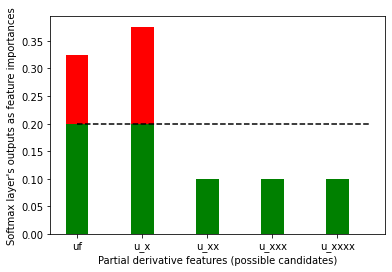

In [29]:
def plot_feature_importance_neural_net(feature_importances, feature_names, threshold=0.5, save_path=None):
    # split it up
    above_threshold = np.maximum(feature_importance - threshold, 0)
    below_threshold = np.minimum(feature_importance, threshold)

    # and plot it
    fig, ax = plt.subplots()
    ax.bar(feature_names, below_threshold, 0.35, color="g")
    ax.bar(feature_names, above_threshold, 0.35, color="r",
            bottom=below_threshold)
    # horizontal line indicating the threshold
    ax.plot([0., 4.5], [threshold, threshold], "k--")
    plt.xlabel("Partial derivative features (possible candidates)")
    plt.ylabel("Softmax layer's outputs as feature importances")
    
    if save_path is not None: fig.savefig(save_path, dpi=200)

plot_feature_importance_neural_net(feature_importance, feature_names,threshold=1/len(feature_names), save_path='../visualization/ks_feature_importances_selector_with_softmax.png')

In [23]:
light = lightgbm.LGBMRegressor(n_estimators=300, learning_rate=0.1, reg_alpha=10)
light = SklearnModel(model=light, X_train=to_numpy(ders), y_train=to_numpy(dys).ravel(), feature_names=feature_names)
light_feature_importance = light.feature_importance()

Done training
Training MSE: 0.0005890103479770972
('uf', 0.3169302870533099)
('u_xx', 0.22378441710603397)
('u_x', 0.1611013473930873)
('u_xxxx', 0.15289982425307558)
('u_xxx', 0.14528412419449327)


In [20]:
# print("Ensemble model")
# sklearn_model = SklearnModel(model=ensemble, X_train=X_np_full, y_train=y_np_full, feature_names=feature_names)
# print('Training GBM algos...')
# print()

xg = xgboost.XGBRegressor(reg_alpha=10)
cat = catboost.CatBoostRegressor(iterations=None, depth=4, learning_rate=0.1, verbose=0, reg_lambda=10)

print("Xgboost")
xg = SklearnModel(model=xg, X_train=to_numpy(ders), y_train=to_numpy(dys).ravel(), feature_names=feature_names)
xg_feature_importance = xg.feature_importance()
print()

print("Catboost")
# Showing the best performance
cat = SklearnModel(model=cat, X_train=to_numpy(ders), y_train=to_numpy(dys).ravel(), feature_names=feature_names)
cat_feature_importance = cat.feature_importance()
print()

Xgboost
Done training
Training MSE: 0.00036422763
('u_xx', 0.3272193719032313)
('u_x', 0.24156895639850134)
('uf', 0.22134472759581697)
('u_xxx', 0.12260762784790438)
('u_xxxx', 0.08725931625454598)

Catboost
Done training
Training MSE: 0.00018550439011075538
('u_xx', 0.2928676094879013)
('uf', 0.2901900573230381)
('u_x', 0.2611325741653077)
('u_xxx', 0.08789615538736091)
('u_xxxx', 0.06791360363639201)



uf 0.3169302870533099
u_x 0.1611013473930873
u_xx 0.22378441710603397
u_xxx 0.14528412419449327
u_xxxx 0.15289982425307558


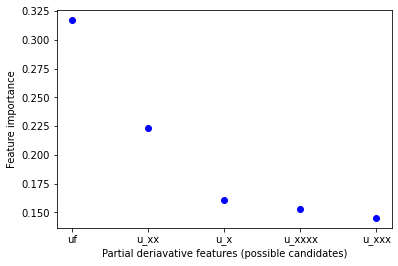

In [26]:
avg_feature_importances = {}
for f in feature_names:
    avg_feature_importances[f] = (light_feature_importance[f])
    print(f, avg_feature_importances[f])

tmp = sorted([(v, f) for (f, v) in avg_feature_importances.items()])[::-1]
xxx = [f for (f, v) in tmp]
yyy = [v for (f, v) in tmp]

plt.plot(yyy, xxx, 'bo')
plt.ylabel("Feature importance")
plt.xlabel("Partial deriavative features (possible candidates)")
# plt.savefig("../visualization/ks_trees_feature_importances_with_softmax.png", dpi=200)
plt.show()